<a href="https://colab.research.google.com/github/jbeaxn/-Data-Blind-System-Impact-on-Price-Structure/blob/main/price_volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[모의 시뮬레이션]**
    Q1 - 블라인드 도입 전후 가격구조 변화 분석


**사용된 데이터** : 가락시장_사과_5개년.zip

**블라인드제 도입시점** : 2022 - 07 -01으로 설정

In [ ]:
# 먼저 실행하여 코랩에 zip파일 직접 업로드
from google.colab import files
uploaded = files.upload()

# 기본 설정
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
sns.set(font_scale=1.2)

Saving 가락시장_사과_5개년.zip to 가락시장_사과_5개년.zip


In [ ]:
# ZIP 압축 풀고 csv 변환 후 병합
import zipfile, os, pandas as pd, glob

zip_path = list(uploaded.keys())[0]
extract_dir = "/content/extracted_fast"

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

excel_files = glob.glob(extract_dir + "/*.xlsx")

df_list = []
for f in excel_files:
    print("Reading:", f)
    tmp = pd.read_excel(f, engine='openpyxl')
    tmp['source_file'] = os.path.basename(f)
    df_list.append(tmp)

df = pd.concat(df_list, ignore_index=True)
df.head()



Reading: /content/extracted_fast/가락시장_사과전체_2023.xlsx
Reading: /content/extracted_fast/가락시장_사과전체_2021.xlsx
Reading: /content/extracted_fast/가락시장_사과전체_2022.xlsx
Reading: /content/extracted_fast/가락시장_사과전체_2024.xlsx
Reading: /content/extracted_fast/가락시장_사과전체_2020.xlsx


,auctn_seq,auctn_seq2,corp_cd,corp_gds_cd,corp_gds_item_nm,corp_gds_vrty_nm,corp_nm,gds_lclsf_cd,gds_lclsf_nm,gds_mclsf_cd,...,trd_clcln_ymd,trd_se,unit_cd,unit_nm,unit_qty,unit_tot_qty,whsl_mrkt_cd,whsl_mrkt_nm,date,source_file
0,10,1,11000102,2001001055,사과,미시마,농협가락(공),6,과실류,1,...,2023-01-03,경매,12,kg,10.0,360.0,110001,서울가락,2023-01-03,가락시장_사과전체_2023.xlsx
1,100,1,11000102,2001001055,사과,미시마,농협가락(공),6,과실류,1,...,2023-01-03,경매,12,kg,10.0,480.0,110001,서울가락,2023-01-03,가락시장_사과전체_2023.xlsx
2,110,1,11000102,2001001055,사과,미시마,농협가락(공),6,과실류,1,...,2023-01-03,경매,12,kg,10.0,330.0,110001,서울가락,2023-01-03,가락시장_사과전체_2023.xlsx
3,120,1,11000102,2001001055,사과,미시마,농협가락(공),6,과실류,1,...,2023-01-03,경매,12,kg,10.0,180.0,110001,서울가락,2023-01-03,가락시장_사과전체_2023.xlsx
4,130,1,11000102,2001001055,사과,미시마,농협가락(공),6,과실류,1,...,2023-01-03,경매,12,kg,10.0,200.0,110001,서울가락,2023-01-03,가락시장_사과전체_2023.xlsx


In [ ]:
# 날짜 처리 + 블라인드 도입 시점 처리
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 블라인드 제도 도입 기준 날짜 설정
blind_start = pd.to_datetime("2022-07-01")
df['blind'] = (df['date']>=blind_start).astype(int)

---------------------------------
# **📌블라인드 도입 전후 가격 변화 분석**
---------------------------------


**✅RQ1. 블라인드 도입 후 전체 평균 낙찰가격의 변화**

-> 전후평균 비교 (by t-test)

In [ ]:
before = df[df['blind']==0]['scsbd_prc']
after  = df[df['blind']==1]['scsbd_prc']

before.mean(), after.mean()

(np.float64(27279.181831698505), np.float64(37959.715453320925))

In [ ]:
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(before, after, equal_var = False)
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_val:.3f}")

T-statistic: -263.62
P-value: 0.000


**✅RQ2. 블라인드 도입 후 가격 변동성이 감소했는가?**

-> 분산 비교 (by levene test)

In [ ]:
from scipy.stats import levene
levene_stat, levene_p_val = levene(before, after)
print(f"Levene Statistic: {levene_stat:.2f}")
print(f"Levene P-value: {levene_p_val:.3f}")

Levene Statistic: 34223.78
Levene P-value: 0.000


In [ ]:
daily_var = df.groupby(['date'])['scsbd_prc'].var()


**✅RQ3. 블라인드 도입 후 산지별 단가 편차가 감소했는가?**

-> 산지별 평균 단가 계산

-> 산지별 표준 편차 비교

In [ ]:
var_before = df[df['blind']==0].groupby('plor_nm')['scsbd_prc'].mean().std()
var_after = df[df['blind']==1].groupby('plor_nm')['scsbd_prc'].mean().std()

print(f"산지별 단가 편차 (도입 전): {var_before:.2f}")
print(f"산지별 단가 편차 (도입 후): {var_after:.2f}")

산지별 단가 편차 (도입 전): 10893.01
산지별 단가 편차 (도입 후): 15757.42


**✅RQ4. 출하자별(corp) 단가 편차가 감소했는가?**

-> corp grouping


In [ ]:
corp_var_before = df[df['blind']==0].groupby('corp_cd')['scsbd_prc'].mean().std()
corp_var_after  = df[df['blind']==1].groupby('corp_cd')['scsbd_prc'].mean().std()

print(f"출하자별 단가 편차 (도입 전): {corp_var_before:.2f}")
print(f"출하자별 단가 편차 (도입 후): {corp_var_after:.2f}")

출하자별 단가 편차 (도입 전): 3087.03
출하자별 단가 편차 (도입 후): 3446.76


# **RESULT : VISUALIZE**

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="findfont:")
warnings.filterwarnings("ignore")


📊 RQ1. 블라인드 도입 후 평균 낙찰 가격 변화

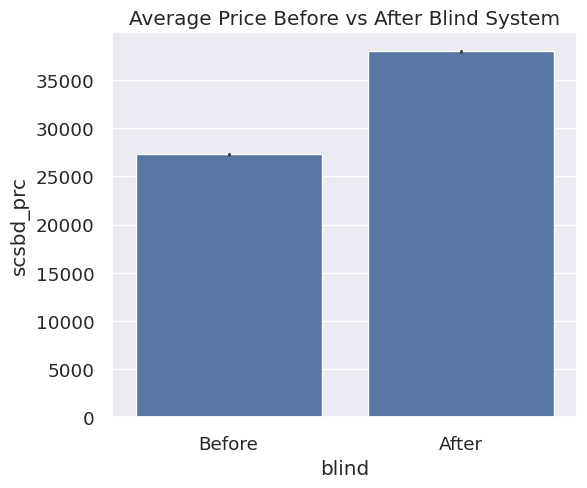

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.barplot(data=df, x='blind', y='scsbd_prc', estimator=np.mean)
plt.xticks([0,1], ['Before','After'])
plt.title("Average Price Before vs After Blind System")
plt.show()

📊RQ2. 블라인드 도입 후 가격 변동성이 감소했는가?

1) 분포(KDE)

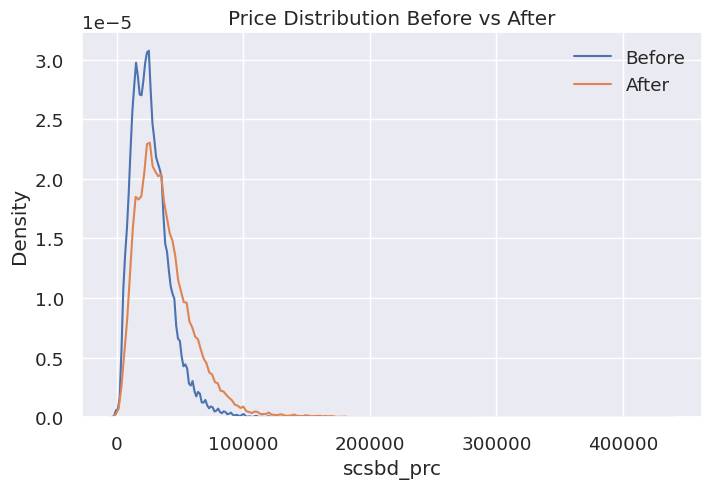

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(df[df['blind']==0]['scsbd_prc'], label="Before")
sns.kdeplot(df[df['blind']==1]['scsbd_prc'], label="After")
plt.title("Price Distribution Before vs After")
plt.legend()
plt.show()

  2. 일별 변동성

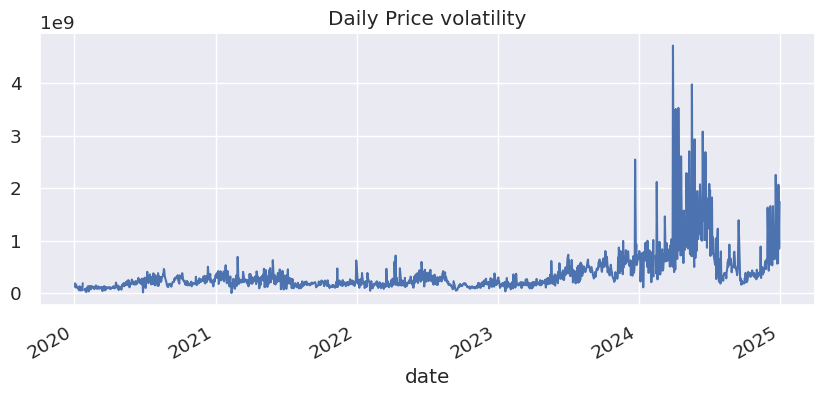

In [ ]:
daily_var = df.groupby('date')['scsbd_prc'].var()

plt.figure(figsize=(10,4))
daily_var.plot()
plt.title("Daily Price volatility")
plt.show()


📊 RQ3. 블라인드 도입 후 산지별 단가 편차가 감소했는가?

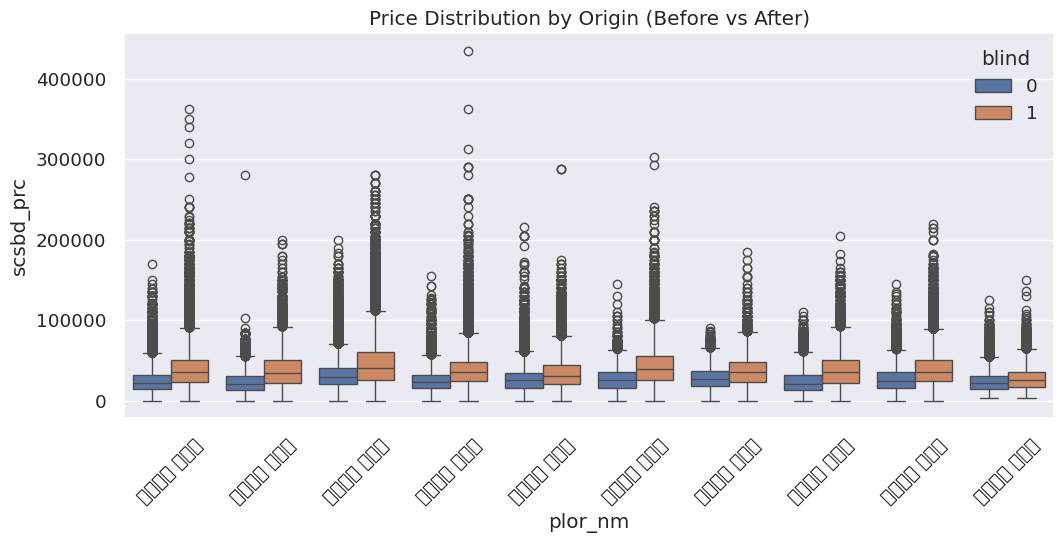

In [ ]:
# 전체를 시각화하면 자료가 깨지므로 상위 산지만 시각화
top_plor = df['plor_nm'].value_counts().index[:10]
plt.figure(figsize=(12,5))
sns.boxplot(
    data=df[df['plor_nm'].isin(top_plor)],
    x='plor_nm',
    y='scsbd_prc',
    hue='blind'
)
plt.xticks(rotation=45)
plt.title('Price Distribution by Origin (Before vs After)')
plt.show()

# 0 -> 도입 전의 데이터
# 1 -> 도입 후의 데이터

📊 RQ4. 블라인드 도입 후 출하자(corp)별 단가 편차가 감소했는가?

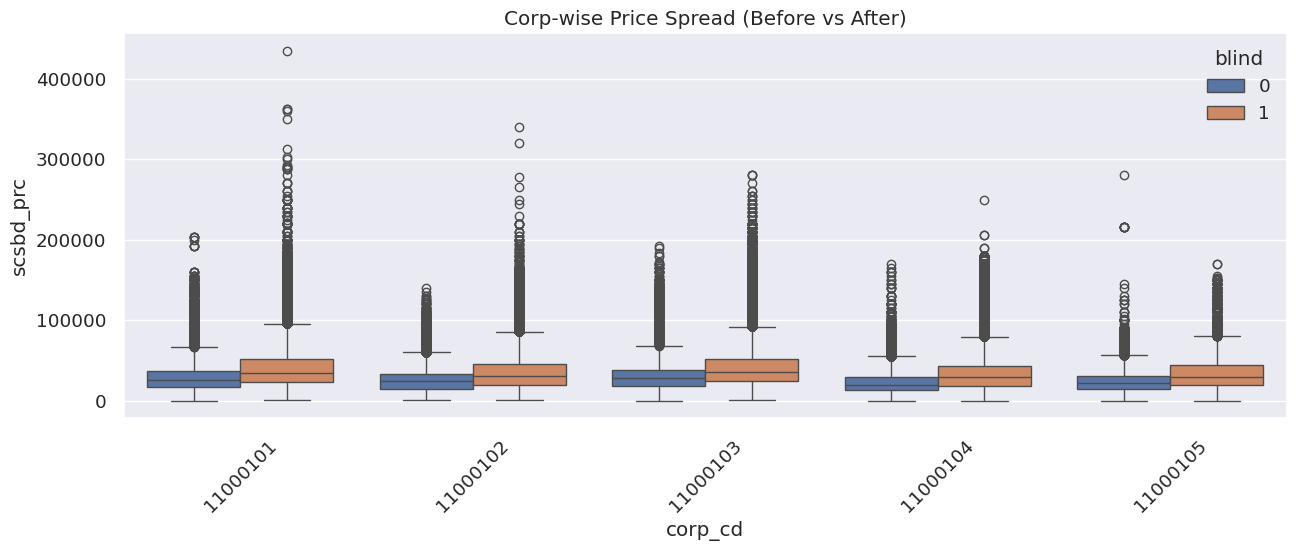

In [ ]:
# 출하자 수가 너무 많으니, 상위 출하자만 시각화
top_corp = df['corp_cd'].value_counts().index[:15]

plt.figure(figsize=(15,5))
sns.boxplot(
    data=df[df['corp_cd'].isin(top_corp)],
    x='corp_cd',
    y='scsbd_prc',
    hue='blind'
)
plt.xticks(rotation=45)
plt.title('Corp-wise Price Spread (Before vs After)')
plt.show()

## **📌분석 결과 요약 및 리뷰**


*   **RQ1. 블라인드 도입 후 전체 평균 낙찰가격의 변화**
    *   블라인드 제도 도입 후 평균 낙찰가격이 **증가**했습니다. (도입 전 약 27,279원에서 도입 후 약 37,959원으로 증가)

*   **RQ2. 블라인드 도입 후 가격 변동성이 감소했는가?**
    *   Levene 테스트 결과 통계적으로 유의미한 분산의 차이가 있었으며, KDE 분포 시각화 및 일별 변동성 그래프를 통해 볼 때 가격 변동성은 오히려 **증가**한 것으로 나타났습니다.

*   **RQ3. 블라인드 도입 후 산지별 단가 편차가 감소했는가?**
    *   산지별 평균 낙찰가격의 표준 편차가 블라인드 제도 도입 후 **증가**했습니다. (도입 전 약 10,893에서 도입 후 약 15,757로 증가)

*   **RQ4. 블라인드 도입 후 출하자별(corp) 단가 편차가 감소했는가?**
    *   출하자별 평균 낙찰가격의 표준 편차 또한 블라인드 제도 도입 후 **증가**했습니다. (도입 전 약 3,087에서 도입 후 약 3,446으로 증가)


**[결론]**

전반적으로 블라인드 제도 도입 이후 **평균 낙찰가격이 상승**했으며,

**가격 변동성 및 산지별/출하자별 단가 편차도 증가**하는 경향을 보였습니다.

블라인드 제도가 의도했던 가격 안정화 및 단가 편차 감소와는 상반되는 결과를 확인할 수 있었습니다.


이러한 결과가 교란요인 때문인지 확인하고자
추가적인 시각화를 진행해보았습니다.


# **📌[교란요인 확인하기]**

 ✔ 공급감소가 교란요인인지 확인

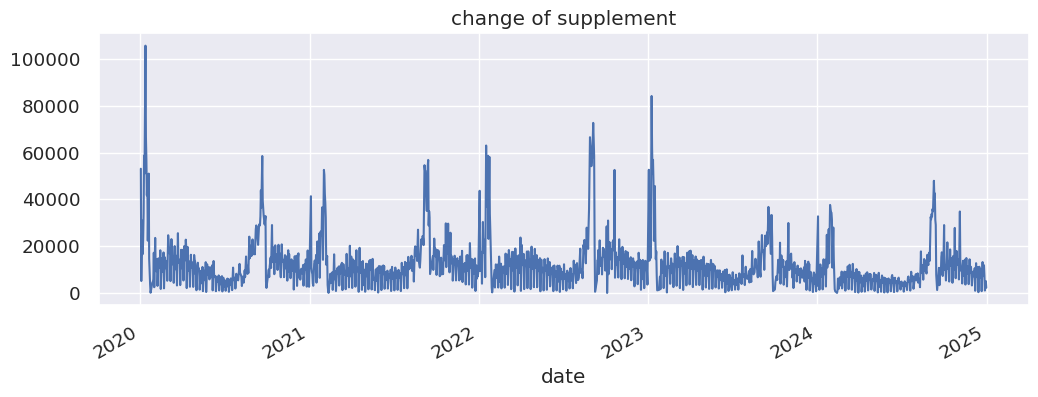

In [ ]:
df.groupby('date')['qty'].sum().plot(figsize=(12,4))
plt.title("change of supplement")
plt.show()

-> 24년도부터 공급량이 줄었음을 확인하였습니다.

 ✔ 산지 구성비 변화가 교란요인인지 확인

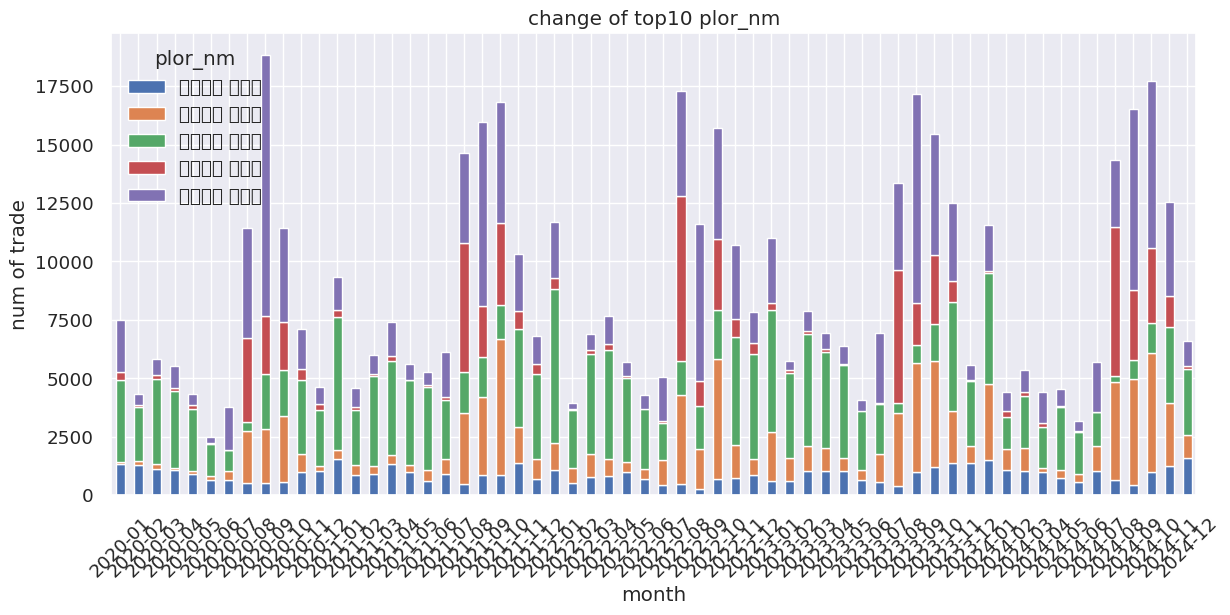

In [ ]:
# 상위 5개 산지 추출
top5_origins = df['plor_nm'].value_counts().head(5).index

df_top5 = df[df['plor_nm'].isin(top5_origins)]

monthly_origin = df_top5.groupby([df_top5['date'].dt.to_period('M'), 'plor_nm']).size()

monthly_origin.unstack().plot(kind='bar', stacked=True, figsize=(14,6))
plt.title("change of top10 plor_nm")
plt.xlabel("month")
plt.ylabel("num of trade")
plt.xticks(rotation=45)
plt.show()



-> 산지 구성비의 변화는 크게 없음을 확인하였습니다.

 ✔등급 / 크기 / 포장규격 변화가 교란요인인지 확인

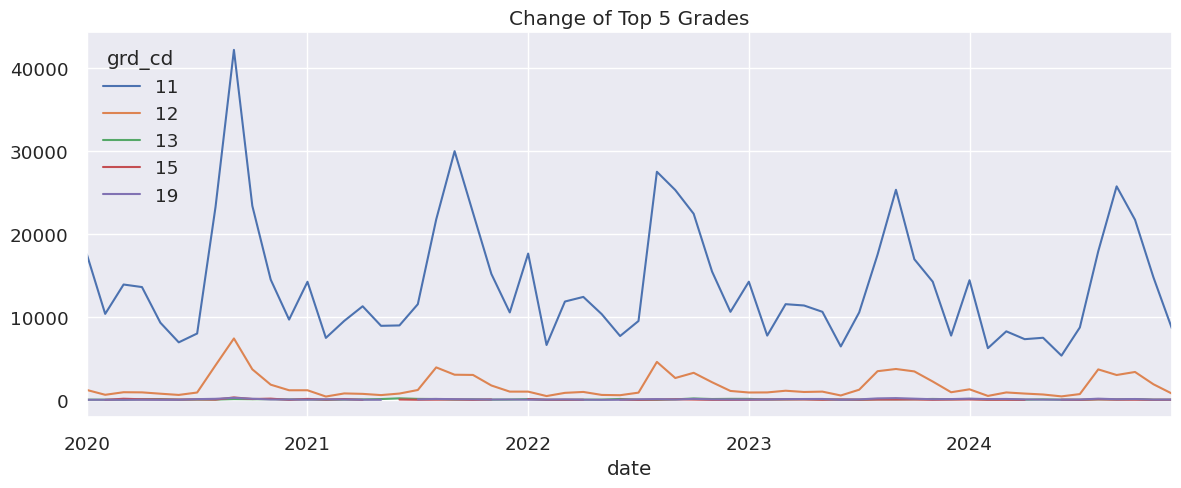

In [ ]:
# 등급별 구성 변화
df['grd_cd'] = df['grd_cd'].astype(str)

top5_grades = df['grd_cd'].value_counts().head(5).index
df_grades_top = df[df['grd_cd'].isin(top5_grades)]

df_grades_top.groupby([df_grades_top['date'].dt.to_period('M'), 'grd_cd']).size()\
    .unstack().plot(figsize=(14,5))
plt.title("Change of Top 5 Grades")
plt.show()


-> 등급 구성비는 크게 변화없음을 확인하였습니다.

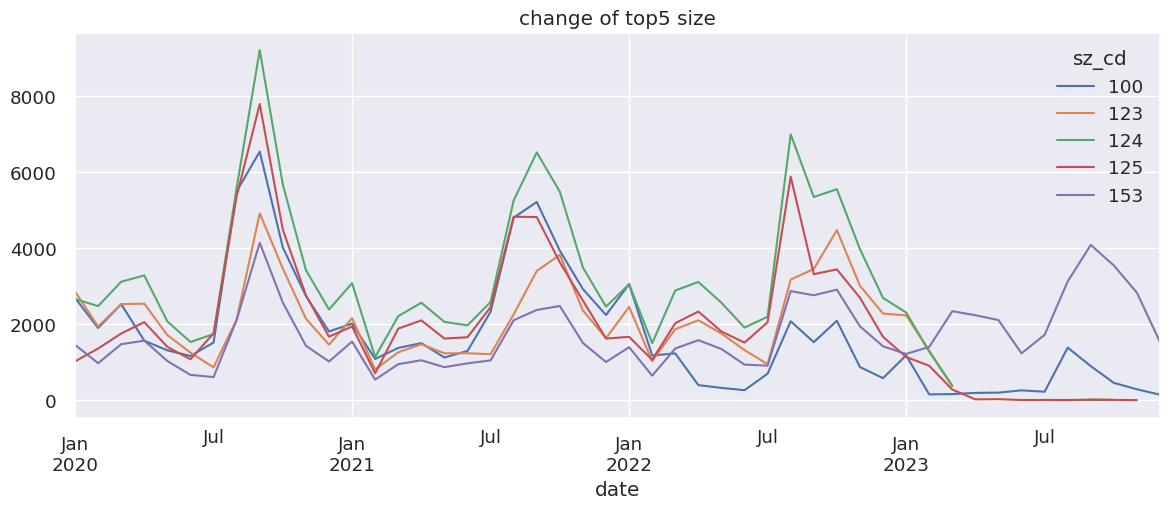

In [ ]:
# 크기 구성 변화
top5_sizes = df['sz_cd'].value_counts().head(5).index
df_sizes_top = df[df['sz_cd'].isin(top5_sizes)]

df_sizes_top.groupby([df_sizes_top['date'].dt.to_period('M'), 'sz_cd']).size()\
    .unstack().plot(figsize=(14,5))
plt.title("change of top5 size")
plt.show()


-> 크기 구성비의 변화는 23년도 이후 뚜렷하게 나타남을 확인하였습니다.

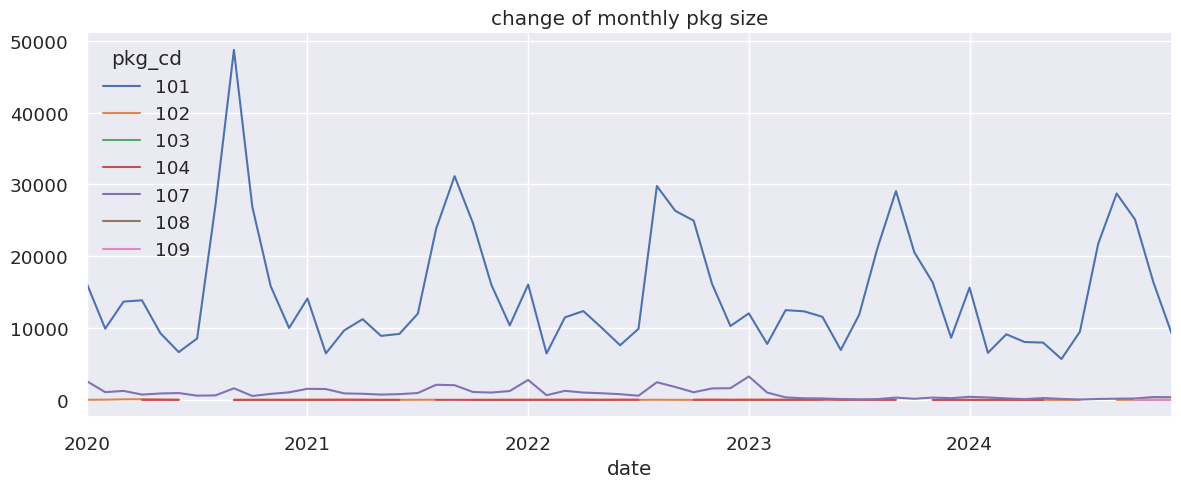

In [ ]:
# 포장 규격 구성 변화
df.groupby([df['date'].dt.to_period('M'), 'pkg_cd']).size().unstack().plot(figsize=(14,5))
plt.title("change of monthly pkg size")
plt.show()


-> 포장 규격 구성비의 변화는 거의 없음을 확인하였습니다.

# **[ RESULT ]**

검색을 통하여 찾아본 결과,
서울 가락시장은 **2022년도 7월 경부터 블라인드 제도를 시행**하였음을 알 수 있었고,

그 시점을 기준으로 블라인드 제도 도입 전 후
가격 양상 비교 시뮬레이션을 진행하였습니다.



블라인드 제도가 효과 있었음을 입증하려면,
가격 변동성 및 각종 편차값들이 감소하여야 하지만,

오히려 증가되는 경향을 보여 **예상과는 다른 결과**를 얻을 수 있었습니다.


단순 결과만으로 블라인드제는 오히려 상황을 악화시켰다는 결론을 내리기 보다는,

교란요인이 존재하여 이러한 결과가 나오게 된 건지
궁금하여 추가적 자료를 시각화하여보니,

**출하량 변화** 및 **크기 구성비 변화**가
시뮬레이션 결과에 영향을 줄 수 있음을 확인하였습니다.


이러한 **교란요인을 통제하기 위해서는, 회귀분석 모델을 사용**한다면,

블라인드 제도 자체의 순수한 영향을 파악하고자 하는 향후 연구에 도움이 될 것 같습니다.

간략히 시뮬레이션을 진행하여보니, 데이터 자체가 꽤 흥미로운 것 같고,

이를 주제로 펼칠 수 있는 연구가 다양할 것 같다는 생각이 많이 듭니다.



# **[출하량 기준 대농/소농 구분 후 낙찰 가격 비교]**
( 추가로 코랩 작성하다보니 교수님께서 하셨던 말씀 중 이 주제에 대해 궁금해져서 간단히 진행해보았습니다. )


In [ ]:
# 출하량 기준 대소농 구분

q10 = df['qty'].quantile(0.10)   # 하위 10%
q90 = df['qty'].quantile(0.90)   # 상위 10%

df['farmer_group'] = 'all'
df.loc[df['qty'] <= q10, 'farmer_group'] = 'small farm'
df.loc[df['qty'] >= q90, 'farmer_group'] = 'large farm'

df['farmer_group'].value_counts()


,count
farmer_group,
all,743754
small farm,114075
large farm,97103


✅ 소농 - 대농 간 낙찰가격 비교

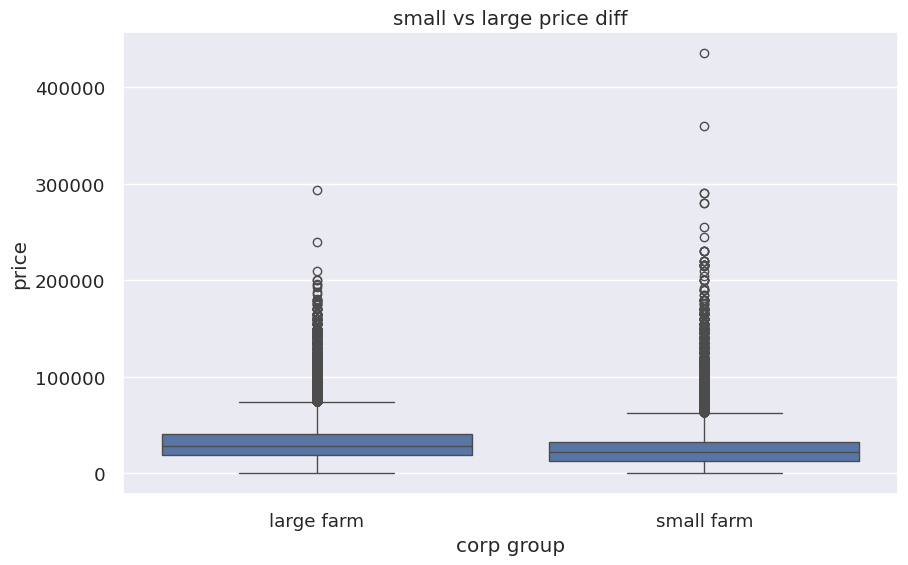

In [ ]:
# 소농 / 대농 낙찰가격 비교 (boxplot)
plt.figure(figsize=(10,6))
sns.boxplot(data=df[df['farmer_group'].isin(['small farm','large farm'])],
            x='farmer_group', y='scsbd_prc')
plt.title("small vs large price diff")
plt.xlabel("corp group")
plt.ylabel("price")
plt.show()


✅ 블라인드제 전후 소농-대농 가격 격차 비교

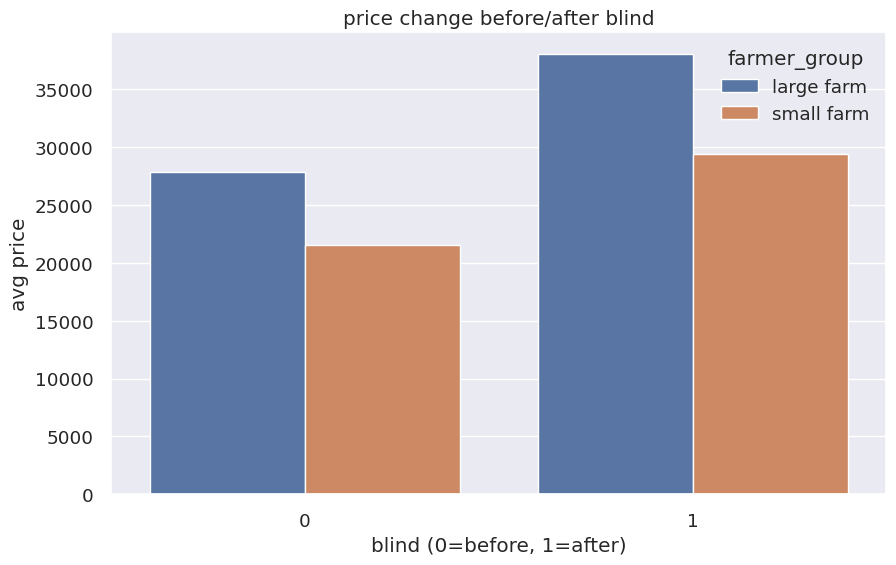

In [ ]:
# 블라인드 도입 전후 가격 격차 비교
df_blind_gap = (
    df[df['farmer_group'].isin(['small farm','large farm'])]
    .groupby(['blind','farmer_group'])['scsbd_prc']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,6))
sns.barplot(data=df_blind_gap, x='blind', y='scsbd_prc',
            hue='farmer_group')
plt.title("price change before/after blind")
plt.xlabel("blind (0=before, 1=after)")
plt.ylabel("avg price")
plt.show()


이건 예상한 대로 대농의 단가가 더 높음을 확인할 수 있었습니다 !

또한 블라인드제 도입 후에도, 대농 - 소농 간의 가격 격차가 줄어들지는 않은 것으로 확인할 수 있었습니다.

# **📌[Regression 관점 추가 연구]** by ols regression

for 블라인드제의 순수 효과 분석 (최소제곱 회귀)

In [ ]:
# 행렬 줄인 뒤 ols regression 실행
import statsmodels.formula.api as smf
import pandas as pd

def keep_top_k(df, column, k=10):
    df[column] = df[column].astype(str)

    value_counts = df[column].value_counts()

    topk_values = value_counts.head(k).index.tolist()
    df[column] = df[column].apply(lambda x: x if x in topk_values else 'other')

    df[column] = pd.Categorical(df[column])
    return df

df_small = df.copy()

df_small = keep_top_k(df_small, 'grd_cd', 10)
df_small = keep_top_k(df_small, 'sz_cd', 10)
df_small = keep_top_k(df_small, 'pkg_cd', 10)
df_small = keep_top_k(df_small, 'plor_nm', 10)
df_small = keep_top_k(df_small, 'corp_cd', 10)

formula_parts = [
    "scsbd_prc ~ blind + qty"
]

categorical_cols = ['grd_cd', 'sz_cd', 'pkg_cd', 'plor_nm', 'corp_cd']

print("Checking unique values for categorical columns in df_small:")
for col in categorical_cols:
    if df_small[col].nunique() > 1:
        formula_parts.append(f"C({col})")
    else:
        unique_val_str = str(df_small[col].iloc[0]) if df_small[col].nunique() == 1 else 'N/A (no unique values)'
        print(f"Warning: Column '{col}' has {df_small[col].nunique()} unique value(s) (e.g., '{unique_val_str}') after filtering and will be excluded from the model.")

formula = " + ".join(formula_parts)
print(f"\nUsing OLS formula: {formula}")

model = smf.ols(formula, data=df_small).fit()

print(model.summary())


Checking unique values for categorical columns in df_small:

Using OLS formula: scsbd_prc ~ blind + qty + C(grd_cd) + C(sz_cd) + C(pkg_cd) + C(plor_nm) + C(corp_cd)
                            OLS Regression Results                            
Dep. Variable:              scsbd_prc   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     8251.
Date:                Tue, 02 Dec 2025   Prob (F-statistic):               0.00
Time:                        07:52:47   Log-Likelihood:            -1.0127e+07
No. Observations:              904636   AIC:                         2.025e+07
Df Residuals:                  904594   BIC:                         2.025e+07
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                             coef    std err 

# **📌 [OLS Regression 결과 요약]**


종속변수: scsbd_prc (낙찰 단가)

주요 설명변수: blind (블라인드 도입 여부)

통제변수: 등급(grd_cd), 크기(sz_cd), 포장규격(pkg_cd), 산지(plor_nm), 출하자(corp_cd)





# **📊 1. 블라인드 제도 효과**
**✔ blind coefficient: +6510.45 (p < 0.001)**

블라인드 제도 도입 후 평균 낙찰가격이 약 6,510원 증가

등급/크기/포장/산지/출하자 효과를 모두 통제한 뒤에도 유의함

블라인드 제도 자체가 가격 상승에 기여했음을 의미



# **📊 2. 출하량(qty) 효과**
**✔ qty coefficient: -0.23 (p = 0.52)**

**통계적으로 유의하지 않음**

이유: 이미 크기(sz_cd)와 포장규격(pkg_cd)가 출하량(qty)와 강하게 연결되어 있기 때문에 qty가 추가적인 설명력을 갖지 못 함

즉, qty가 가격과 무관하다는 게 아닌,

qty효과는 다른 변수가 설명해버려서 회귀에서는 유의하지 않은 것(다중공선성)



# **📊 3. 등급(grd_cd) 효과**

등급은 낙찰가에 매우 큰 영향을 미침

주요 계수 :

특(A급): +10,700원

상(B급): –3,785원

보통(C급): –7,163원

**→ 등급이 가격의 가장 큰 결정 요인 중 하나**



# **📊 4. 크기(sz_cd) 효과**

과일 크기(또는 규격) 역시 큰 영향을 미침

주요 계수 예시:

25내: +6,850원

40내: +12,150원

20내(대과): +20,200원

**→ 크기가 클수록 가격이 높아지는 구조를 확인**



# **📊 5. 포장규격(pkg_cd) 효과**

일부 포장규격은 +2만~4만원 프리미엄

특정 규격은 음(-)의 영향

**→ 포장 방식이 단가에 직접적인 영향을 줌**



# **📊 6. 산지(plor_nm) 효과**

고가 산지:

청송군: +6,856원

김천시: +5,905원

저가 산지:

괴산군: –5,074원

영천시: –1,564원

**→ 산지에 따른 가격차이 존재**



# **📊 7. 출하자(corp_cd) 효과**

출하자 간에도 가격 차이가 존재

이는 농가의 브랜드/품질평판이 반영된 결과로 해석 가능



# **📊 8. 모델 적합도**
**✔ R-squared: 0.272**

약 27%의 가격 변동을 설명

실거래 경매 시장이라는 특성상 양호한 수준

**✔ F-statistic: 매우 유의함 (p < 0.001)**

**→ 전체 모형은 통계적으로 유의미함**



# **📌 [종합 결론]**

블라인드 제도는 **모든 교란요인을 통제한 뒤에도 약 +6,510원의 유의한 가격 상승** 효과가 있었습니다.

단가 결정 주요 요인은 **등급 > 크기 > 산지 > 출하자** 순.

출하량(qty)은 크기/포장규격 변수와 중복 설명되어 유의하지 않았습니다.

즉, 동일한 품질·규격의 상품만 비교했을 때는 블라인드 제도가 가격을 상승시키는

순수한 효과가 존재함을 확인할 수 있었습니다.

# **📌 [출하량과 경매낙찰가의 관계 시각화]**
 - 출하량이 많으면 낙찰가가 높아지는가? (대농이 출하량 많고, 낙찰가 높으니까)

<Axes: xlabel='total_qty', ylabel='avg_price'>

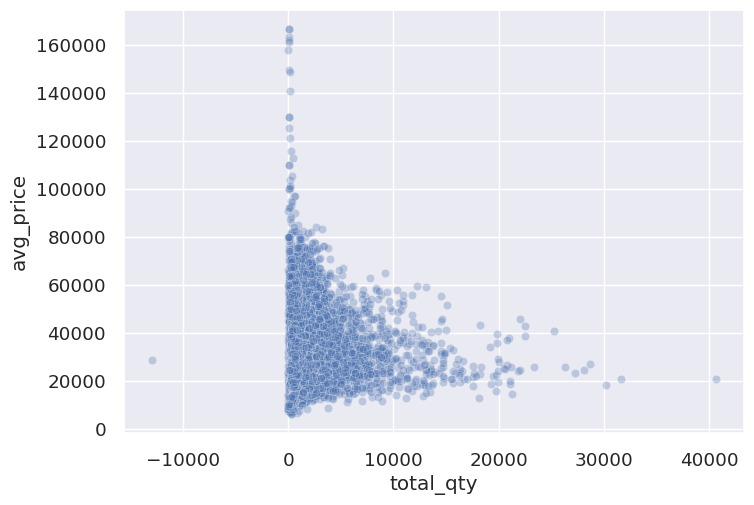

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#출하량과 경매낙찰가 관계 보이기
daily_farm = df.groupby(['corp_cd', 'date']).agg(
    total_qty=('qty','sum'),
    avg_price=('scsbd_prc','mean')
).reset_index()

sns.scatterplot(data=daily_farm, x='total_qty', y='avg_price', alpha=0.3)


-> 대농-소농 간 낙찰가를 비교하였을 땐, **대농의 평균가가 더 높**았습니다.

-> 흥미롭게도 **동일 조건에서 출하량이 증가하면 가격이 떨어지는 경향이 나타남**을 확인하였습니다.




저는 단순히 **대농이 '출하량이 많아서' 가격이 높은 거**라 생각했지만,

이 분석으로 **대농이 더 좋은 등급, 품질, 크기, 포장, 산지 등**을 갖고 있기 때문에

**가격이 높을 거**라 추측해 볼 수 있었습니다.


즉, **대농-소농 가격 차이는 구조적 요인**,

**출하량-가격의 음의 관계는 시장 수급** 때문임을 확인할 수 있었습니다.

# **📌[도입 직후 가격이 튀다가 정상화 되었는가? ]**
-즉, 정책 효과가 시간에 따라 변화하는가 (event study)

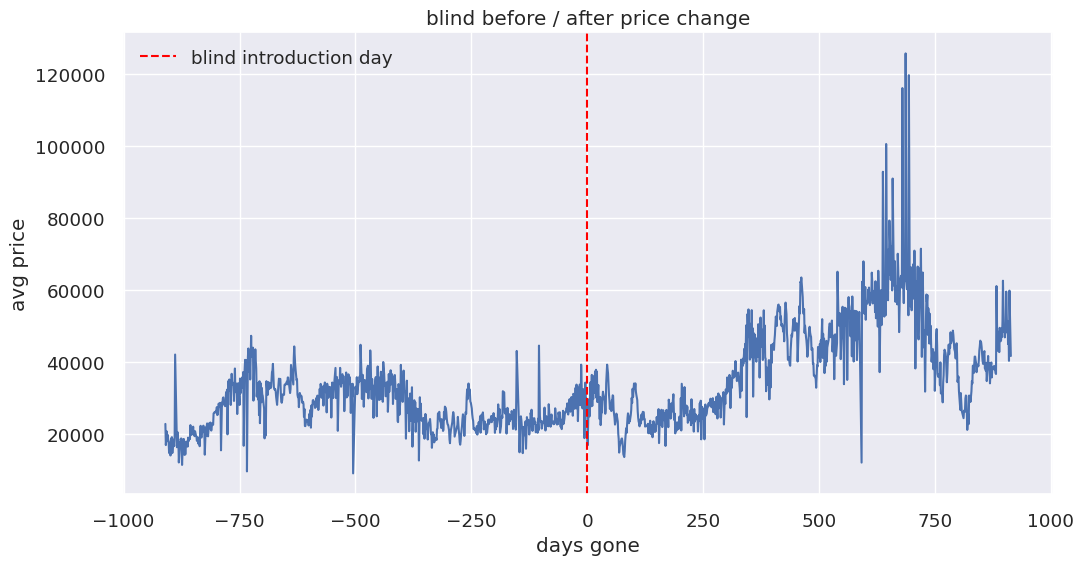

In [ ]:
# 경과일 계산
df['days_after_blind'] = (df['date'] - blind_start).dt.days

import matplotlib.pyplot as plt
import seaborn as sns

# 도입 전후 날짜별 평균 가격 계산
event_df = df.groupby('days_after_blind')['scsbd_prc'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=event_df, x='days_after_blind', y='scsbd_prc')

# 블라인드 도입일 표시
plt.axvline(0, color='red', linestyle='--', label='blind introduction day')

plt.title('blind before / after price change')
plt.xlabel('days gone')
plt.ylabel('avg price')
plt.legend()
plt.show()


**[결과에 대한 주관적 의견]**

블라인드 도입 직전과 직후 (+-90~180일) 가격에는 유의한 변화가 거의 없었습니다.

도입 후 500~800일 시점의 가격 상승은 다른 요인들 (트렌드변화, 시장이슈 등..)으로 인한 것이며

이를 블라인드 정책 효과로 해석할 수는 없을 것 같습니다.

# **📌[ OLS Regression + Event Study 종합 해석 ]**
- AI에게 질문해보았습니다.

OLS 분석 결과 블라인드 경매 도입은 동일한 품질·규격을 가진 상품만 비교했을 때 낙찰가를 유의하게 상승시키는 효과가 존재하는 것으로 나타났다.
반면 Event Study에서는 도입 직후 전체 평균 가격의 큰 변화가 관측되지 않았는데, 이는 블라인드 제도가 시장 전체 가격 수준을 높이기 위한 정책이라기보다, 품질 기반의 공정한 가격 형성을 유도하기 위한 제도라는 점을 시사한다. 즉, 블라인드 제도는 ‘전체 평균 가격 상승’과 같은 거시적 지표에서는 뚜렷한 변화가 나타나지 않지만, 개별 거래 수준에서는 특정 산지·법인의 영향 축소 및 공정성 개선을 통해 ‘동일조건 상품의 가격을 정상화하는 효과’를 가지는 것으로 해석할 수 있다.

# **📌 한 줄 요약**

OLS → 통제하면 블라인드 효과가 선명히 나타남 (순수한 정책효과 존재)

Event Study → 전체 평균은 크게 변하지 않음 (정책 목표가 평균가격이 아니므로 당연한 현상)

→ 둘은 서로 모순되지 않음. 오히려 상호보완적으로 정책 효과를 설명함.

# **[마지막 추가의견]**

하지만 실제 시장에서는 소농·중소규모 산지에는 이득이 적거나 손해 가능성이 있어,

 정책의 형평성 문제는 여전히 존재할 것으로 보고

subgroup분석을 통해 추가적인 연구를 진행하여보면 좋을 것 같습니다.